# Exploration of generated molecules
1. There is a function to load the grid form the visualization files: `util.timesdata_to_array` but this only loads the grid and not the channels as shown below.
2. The generated grid data was written to `.npy` files.
3. Converting the grid data to `.pdb` files that can be easier to visualize.

In [1]:
import numpy as np
import sys
sys.path.append("../zeodiff") # we did not install zeodiff, thus use this trick to access all members

### 1. Loading data from visualization files

In [2]:
from util import timesdata_to_array
samples_vf_40 = timesdata_to_array(root="../generated_samples/sample_vf_0.40/")

In [3]:
print(f"{samples_vf_40.shape=}")
print(f"{samples_vf_40[1].shape=}")

samples_vf_40.shape=(10, 32, 32, 32)
samples_vf_40[1].shape=(32, 32, 32)


In [4]:
# furthermore the values are those of the energy (see high values like 5000)
samples_vf_40[1][3][:]

array([[1095.1825 , 3495.5574 , 4953.8447 , ..., 5003.782  , 4975.7207 ,
        5052.597  ],
       [ 909.37317, 2309.8848 , 4933.8257 , ..., 4949.3486 , 4985.4766 ,
        5020.1055 ],
       [1083.5867 , 2077.7974 , 4980.6826 , ..., 4941.6777 , 4934.7817 ,
        4995.852  ],
       ...,
       [3355.6475 , 4930.271  , 4956.8936 , ..., 4929.643  , 4946.9614 ,
        4957.6445 ],
       [1658.5724 , 4977.0864 , 4964.0957 , ..., 4951.7676 , 4972.768  ,
        4957.657  ],
       [1156.3905 , 4366.663  , 5005.172  , ..., 5055.1196 , 5021.4634 ,
        4892.675  ]], dtype=float32)

### 2. Contents of generated sample.npy
(Written at the same time as visualization files)

In [5]:
sample_1=np.load('../generated_samples/sample_hoa_50/sample_1.npy')
sample_1.shape

(3, 32, 32, 32)

3 channels (energy, Si, O) and the grid is of 32x32x32.
- O and Si: values $\in$ [-1, 1]

In [6]:
print(f"Min value in O channel: {np.min(sample_1[2])}")
print(f"Max value in O channel: {np.max(sample_1[2])}")
print(f"Min value in Si channel: {np.min(sample_1[1])}")
print(f"Max value in Si channel: {np.max(sample_1[1])}")

Min value in O channel: -0.9711060488312816
Max value in O channel: 1.040777847370163
Min value in Si channel: -1.02035079960555
Max value in Si channel: 1.0116691683838206


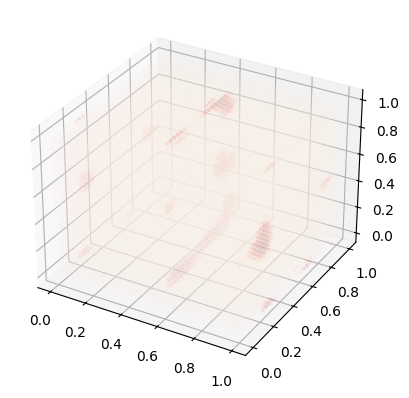

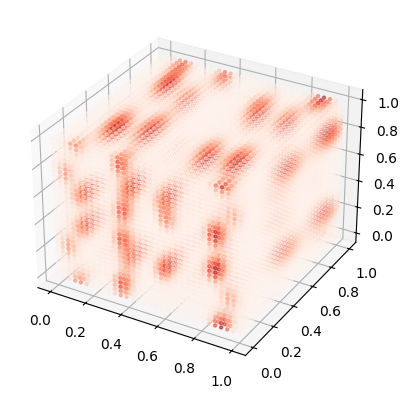

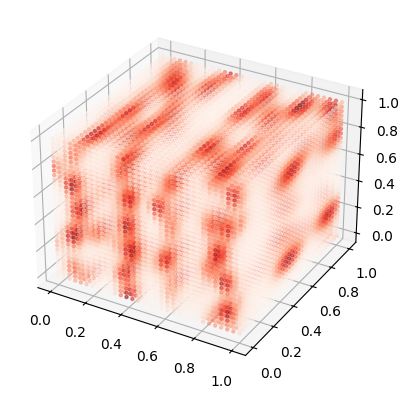

In [7]:
from dataset import visualize_3d
visualize_3d(sample_1, 0) # griddata -> energy
visualize_3d(sample_1, 1) # Si
visualize_3d(sample_1, 2) # O

The sample is streched because we do not consider the lattice size.

In [8]:
def plot_sample(n: int, threshold=0.9):
    """Makes a 3d interactive plot of the Silicium and Oxigen atoms in a generated zeolyte
       Args:
       - n: id of the sample
    """
    import numpy as np
    import sys
    import matplotlib.pyplot as plt
    sys.path.append("../zeodiff") # we didnt install zeodiff, thus use this trick to access all members
    sample_n=np.load(f"../generated_samples/sample_hoa_50/sample_{n}.npy")

    x,y,z = np.mgrid[0:1:32j, 0:1:32j, 0:1:32j]
    #energy = sample_n[0,:,:,:]
    Si = sample_n[1,:,:,:]
    O = sample_n[2,:,:,:]

    %matplotlib widget
    fig = plt.figure()
    ax = fig.add_subplot(projection='3d')
    mask_O =(O >= threshold)

    ax.scatter(x[mask_O], y[mask_O], z[mask_O], c=Si[mask_O], cmap='Reds', s=1, alpha=0.5)
    ax.scatter(x[mask_O], y[mask_O], z[mask_O], c=O[mask_O], cmap='Blues', s=1, alpha=0.5, marker='s')

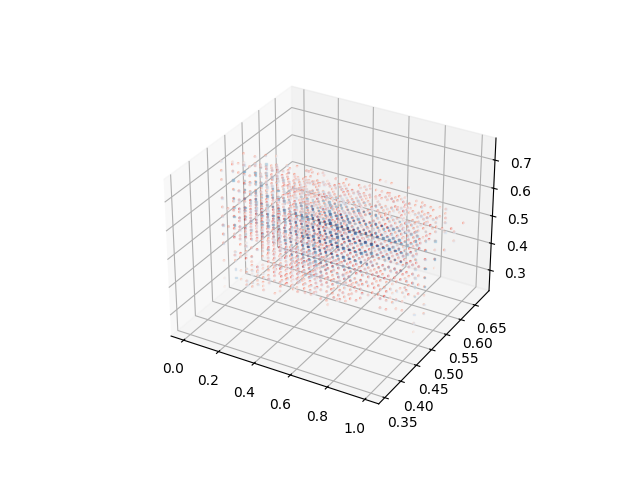

In [9]:
# this plots the sample_3 with a threshold of 0.999
plot_sample(3, threshold=0.999)

### 3. Step 1: filtering the data

In [10]:
def flood_fill(grid, x, y, z, visited):
    """
    Perform a 3D flood-fill algorithm to find all connected points in a grid
    that have values greater than a specified threshold.

    Args:
    grid (numpy.ndarray): A 3D numpy array representing the density grid.
    x (int): The x-coordinate of the starting point.
    y (int): The y-coordinate of the starting point.
    z (int): The z-coordinate of the starting point.
    visited (numpy.ndarray): A 3D boolean numpy array that keeps track of visited points.

    Returns:
    list of tuple: A list of coordinates (x, y, z) that are part of the detected volume.
    """
    if x < 0 or x >= grid.shape[0] or y < 0 or y >= grid.shape[1] or z < 0 or z >= grid.shape[2]:
        return []

    if visited[x, y, z] or grid[x, y, z] <= 0.7:
        return []

    visited[x, y, z] = True
    volume = [(x, y, z)]

    # Check neighbors in 3D space
    for dx in [-1, 0, 1]:
        for dy in [-1, 0, 1]:
            for dz in [-1, 0, 1]:
                if dx != 0 or dy != 0 or dz != 0:
                    volume += flood_fill(grid, x + dx, y + dy, z + dz, visited)
    
    return volume

def calculate_weighted_mean(grid, volume):
    """
    Calculate the weighted mean of the grid coordinates based on their corresponding Gaussian values.

    Args:
    grid (numpy.ndarray): A 3D numpy array representing the density grid.
    volume (list of tuple): A list of coordinates (x, y, z) representing a volume in the grid.

    Returns:
    numpy.ndarray: The weighted mean of the grid coordinates.
    """
    weighted_sum = np.array([0.0, 0.0, 0.0])
    total_weight = 0.0
    for x, y, z in volume:
        value = grid[x, y, z]
        weighted_sum += np.array([x, y, z]) * value
        total_weight += value
    return weighted_sum / total_weight

def find_atomic_positions(grid):
    """
    Find atomic positions in a 3D density grid based on Gaussian volumes.

    Args:
    grid (numpy.ndarray): A 3D numpy array representing the density grid.

    Returns:
    list of numpy.ndarray: A list of atomic positions calculated as the weighted mean of grid coordinates, projected onto 0-1 fractional coords.
    """
    visited = np.zeros_like(grid, dtype=bool)
    atomic_positions = []
    for x in range(grid.shape[0]):
        for y in range(grid.shape[1]):
            for z in range(grid.shape[2]):
                if grid[x, y, z] > 0.7 and not visited[x, y, z]:
                    volume = flood_fill(grid, x, y, z, visited)
                    atomic_position = calculate_weighted_mean(grid, volume)
                    atomic_positions.append(atomic_position)
    atomic_positions = np.array(atomic_positions)
    # to take centers of voxels and then divide by the number of voxels to get fractional coords
    return (atomic_positions + 0.5)/32 

In [11]:
from scipy.stats import multivariate_normal

def create_gaussian_grid(centers, cov=[[0.003, 0, 0], [0, 0.003, 0], [0, 0, 0.003]]):
    # Define the grid
    x, y, z = np.linspace(0, 1, 32), np.linspace(0, 1, 32), np.linspace(0, 1, 32)
    x, y, z = np.meshgrid(x, y, z, indexing='ij')
    
    # Combine the grid coordinates into a single array
    pos = np.empty(x.shape + (3,))
    pos[:, :, :, 0] = x
    pos[:, :, :, 1] = y
    pos[:, :, :, 2] = z
    
    # Initialize grid to zeros
    grid = np.zeros((32, 32, 32))

    # Add Gaussian distributions for each center
    for center in centers:
        rv = multivariate_normal(center, cov)
        grid += rv.pdf(pos)
    
    # Normalize and scale grid to range from -1 to 1
    grid -= np.min(grid)
    grid /= np.max(grid)
    grid = 2 * grid - 1
    
    return grid

#### Example usage

In [12]:
# Example usage on synthetic data
centers = [
    [0.5, 0.5, 0.5], 
    [0.7, 0.7, 0.7], 
    [0.1, 0.5, 0.5],
    [0.2, 0.1, 0.8],
    [0.8, 0.1, 0.2],
    [0.9, 0.8, 0.6]
]

grid = create_gaussian_grid(centers)

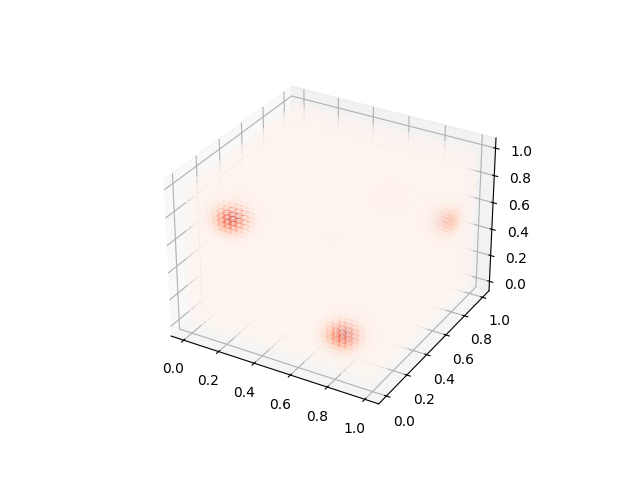

In [13]:
# Visualization of this example
import matplotlib.pyplot as plt
fig = plt.figure()
ax = fig.add_subplot(projection='3d')
x,y,z = np.mgrid[0:1:32j, 0:1:32j, 0:1:32j]
ax.scatter(x, y, z, c=grid, cmap='Reds', s=5, alpha=0.5)

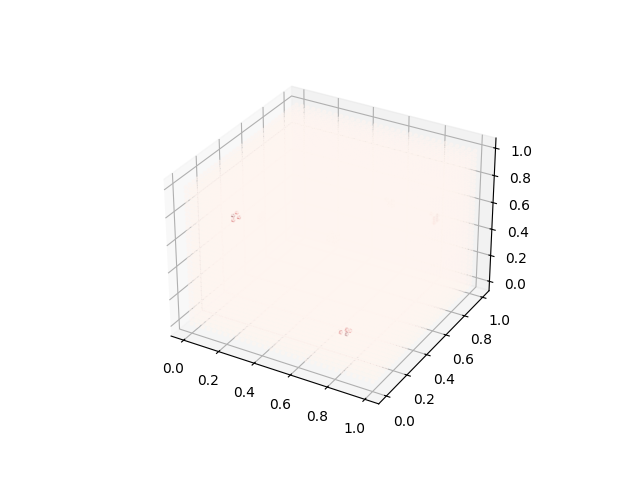

In [14]:
# Filtering out in ZeoDiff they use 0.7
grid[grid < 0.7] = 0 
fig = plt.figure()
ax = fig.add_subplot(projection='3d')
x,y,z = np.mgrid[0:1:32j, 0:1:32j, 0:1:32j]
ax.scatter(x, y, z, c=grid, cmap='Reds', s=5, alpha=0.5)

Number of found atom_positions: 6
Actual: 6
[0.1, 0.5, 0.5] [0.109375 0.5      0.5     ]
[0.2, 0.1, 0.8] [0.21061943 0.1162955  0.78938057]
[0.5, 0.5, 0.5] [0.5 0.5 0.5]
[0.7, 0.7, 0.7] [0.69561558 0.69561526 0.69561149]
[0.8, 0.1, 0.2] [0.78938057 0.1162955  0.21061943]
[0.9, 0.8, 0.6] [0.88514894 0.78546381 0.59698144]


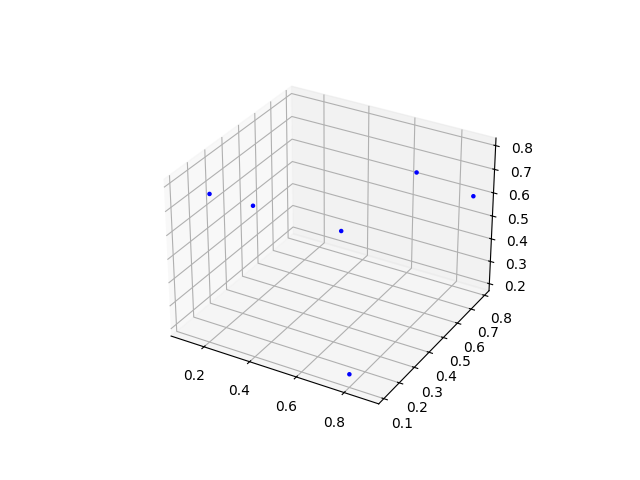

In [15]:
atomic_positions = find_atomic_positions(grid)
print(f'Number of found atom_positions: {len(atomic_positions)}\nActual: {len(centers)}')
for x, y in zip(sorted(atomic_positions, key=lambda x: (x[0], x[1], x[2])), sorted(centers, key=lambda x: (x[0], x[1], x[2]))):
    print(y, x)

fig = plt.figure()
ax = fig.add_subplot(projection='3d')
x, y, z = atomic_positions[:,0], atomic_positions[:,1], atomic_positions[:,2]
ax.scatter(x, y, z, c='b', s=5, alpha=1) 
# the centers do match, but matplotlib does not plot it very well without the grid there

#### Example with a generated sample

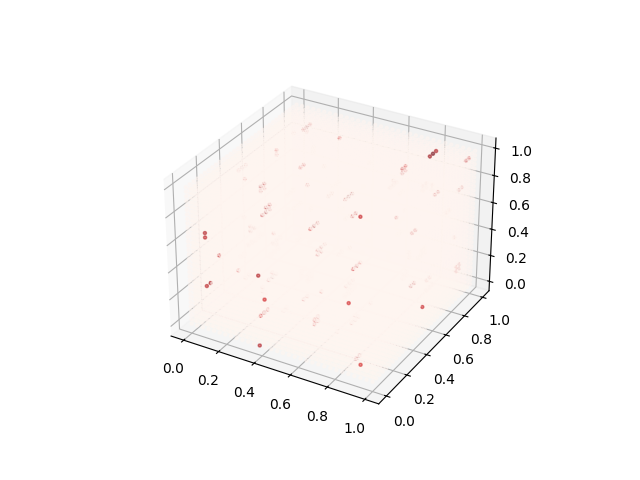

In [16]:
from dataset import visualize_3d

sample_1 = np.load('../generated_samples/sample_hoa_50/sample_1.npy')
cell_1 = np.load('../generated_samples/sample_hoa_50/cell_1.npy')
sample_1[sample_1 > -0.7] = 0 # greater than -0.7, cause -data
visualize_3d(sample_1, 2)

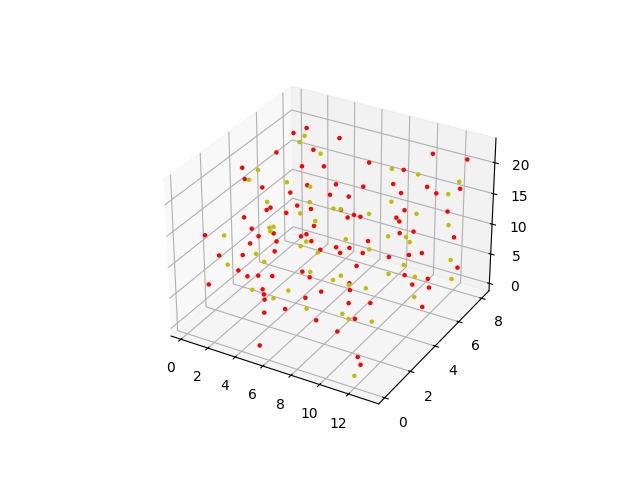

In [17]:
atomic_positions_Si = find_atomic_positions(-sample_1[1]) #using -data again here
atomic_positions_O = find_atomic_positions(-sample_1[2])

# transforming unitary cell to the actual cell size
atomic_positions_Si = atomic_positions_Si * cell_1
atomic_positions_O = atomic_positions_O * cell_1

fig = plt.figure()
ax = fig.add_subplot(projection='3d')

x, y, z = atomic_positions_Si[:,0], atomic_positions_Si[:,1], atomic_positions_Si[:,2]
ax.scatter(x, y, z, c='y', s=5, alpha=1)

x, y, z = atomic_positions_O[:,0], atomic_positions_O[:,1], atomic_positions_O[:,2]
ax.scatter(x, y, z, c='r', s=5, alpha=1) 

#### 4. Generate .pdb files with post-treated samples

In [18]:
import mdtraj as md

def export_to_pdb(atomic_positions_Si, atomic_positions_O, root_and_name_file:str):
    n_si = len(atomic_positions_Si)
    n_O = len(atomic_positions_O)

    top = md.Topology()
    chain = top.add_chain()
    res_Si = top.add_residue('Silicon', chain)
    res_O = top.add_residue('Oxygen', chain)
    for i in range(n_si):
        top.add_atom('Si', md.element.silicon, res_Si)
    for i in range(n_O):
        top.add_atom('O', md.element.oxygen, res_O)

    total_xyz = np.concatenate([atomic_positions_Si, atomic_positions_O])
    #TODO multiply each axis with box_side_length here

    trj = md.Trajectory(total_xyz, top)
    trj.save_pdb(root_and_name_file + '.pdb')

In [19]:
export_to_pdb(atomic_positions_Si, atomic_positions_O, "test")

### 5. Complete workflow for generating the visualization

In [20]:
path_to_generated_samples = "../generated_samples/sample_hoa_50/"

In [21]:
import glob
file_list = glob.glob(path_to_generated_samples+'sample_*.npy')
file_list.sort()
cell_list = glob.glob(path_to_generated_samples+'cell_*.npy')
cell_list.sort()

In [22]:
for i, path_i in enumerate(file_list):
    sample_i=np.load(path_i)
    sample_i[sample_i > -0.7] = 0 # greater than -0.7, cause -data
    atomic_positions_Si = find_atomic_positions(-sample_i[1]) #using -data again here
    atomic_positions_O = find_atomic_positions(-sample_i[2])

    export_to_pdb(atomic_positions_Si, atomic_positions_O, path_to_generated_samples+"sample_"+str(i))

    # re-scale by the cell size
    cell_i = np.load(cell_list[i])
    atomic_positions_Si = atomic_positions_Si * cell_i/10
    atomic_positions_O = atomic_positions_O * cell_i/10
    # divide by 10 because mdtraj interprets the coords as nm (so 1 is 10 A)

    export_to_pdb(atomic_positions_Si, atomic_positions_O, path_to_generated_samples+"scaled_sample_"+str(i))